In [15]:
print("Importing...")
from GCN import *
from datetime import datetime
from utils.my_utils import *
from utils.util import *
import time
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import os
import math
from train_utils import *
import networkx as nx  # graphml visualization
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)
print("Done importing")

Importing...
Done importing


In [16]:
#check gpu
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.3


In [17]:
print("Settings")

run_folder="../"
dataset = "Traceparts_6"
STEP_dataset= dataset + "/STEP_models/"
graphml_dataset = dataset + "/Graphml_Models/"
learning_rate=0.0005
batch_size=1
#num_epochs=50
num_epochs=100
dropout=0.5


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print("The calculations will be performed on the device:", device)

# save paths
model_name = dataset + "_" + str(datetime.today().strftime('%m-%d'))
out_dir = os.path.abspath(os.path.join(run_folder, "./results/runs_GAE", dataset))
if not os.path.exists(out_dir + "/Models/"):
    os.makedirs(out_dir + "/Models/")
save_path = out_dir + "/Models/" + model_name
print("Results will be saved in:", out_dir)
print("    The model will be saved as:", save_path)

Settings
The calculations will be performed on the device: cuda:0
Results will be saved in: C:\Users\sjwoo\3D_STEP_Classification\results\runs_GAE\Traceparts_6
    The model will be saved as: C:\Users\sjwoo\3D_STEP_Classification\results\runs_GAE\Traceparts_6/Models/Traceparts_6_11-16


### CONVERT STEP 3D Models to GRAPHS
To convert STEP models into Graphml data we use the **make_graphh_dataset** Python scripts. It generates an indirect graph from each STEP file.
The function takes two input: 1) the path of the STEP dataset and 2) the output directory where it's gonna write the graph dataset.
To avoid generating each graphs every run, the graph are saved as a **.graphml** format and then reload at subsequent runs.

In [6]:
from Graph_convertion.step_2_graph import make_graphh_dataset

print("Converting STEP dataset in Graphml dataset")
make_graphh_dataset(os.path.abspath(os.path.join(run_folder,"Datasets",STEP_dataset)), os.path.abspath(os.path.join(run_folder,"Datasets",graphml_dataset)))
print("Done converting")

Converting STEP dataset in Graphml dataset


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\sjwoo\\3D_STEP_Classification\\Datasets\\Traceparts_6\\STEP_models/'

### We load the graph dataset
The list of all graph is loaded and divided in train, test and validation set

In [18]:
print(graphml_dataset)
print(os.getcwd())

Traceparts_6/Graphml_Models/
C:\Users\sjwoo\3D_STEP_Classification\Graph_classification


In [4]:
print("Loading Graph data...")
use_degree_as_tag = False
fold = 0
graphs, num_classes = my_load_data(graphml_dataset, use_degree_as_tag)
print(graphs)
print(num_classes)
train_graphs, test_graphs = separate_data(graphs, fold)
print(train_graphs)
print(test_graphs)
train_graphs, valid_graphs = split_data(train_graphs, perc=0.9)
print("# training graphs: ", len(train_graphs))
print_data_commposition(train_graphs)
print("# validation graphs: ", len(valid_graphs))
print_data_commposition(valid_graphs)
print("# test graphs: ", len(test_graphs))
print_data_commposition(test_graphs)
# Num of different STEP entities founded in the graph dataset
feature_dim_size = graphs[0].node_features.shape[1]
print("Loading data... finished!")

Loading Graph data...
dataset_path: ../Datasets/Traceparts_6/Graphml_Models//
Loading class: 0
Loading class: 1
Loading class: 2
Loading class: 3
Loading class: 4
Loading class: 5
# classes: 6
# maximum node tag: 80
# data: 600
[<utils.util.S2VGraph object at 0x0000016EBFFB3D00>, <utils.util.S2VGraph object at 0x0000016EBFFF82B0>, <utils.util.S2VGraph object at 0x0000016ECB23E4C0>, <utils.util.S2VGraph object at 0x0000016EBFFA8D00>, <utils.util.S2VGraph object at 0x0000016ECB23E9D0>, <utils.util.S2VGraph object at 0x0000016EBFFC9310>, <utils.util.S2VGraph object at 0x0000016ECD21EA90>, <utils.util.S2VGraph object at 0x0000016ECD21EF70>, <utils.util.S2VGraph object at 0x0000016ECD21EF40>, <utils.util.S2VGraph object at 0x0000016ED3ED83A0>, <utils.util.S2VGraph object at 0x0000016EBFF9BD30>, <utils.util.S2VGraph object at 0x0000016ED3ED8490>, <utils.util.S2VGraph object at 0x0000016ED3ED84F0>, <utils.util.S2VGraph object at 0x0000016ED3ED85E0>, <utils.util.S2VGraph object at 0x0000016ED3

### Model
We create a Graph Convolutional Neural Network model: the convolutional layers are followed by an attention mechanism and finally by fully connected layers.

In [19]:
print("Creating model")

# Create a GCN model
model = GCN_CN_v4_AE(feature_dim_size=feature_dim_size, num_classes=num_classes, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_batches_per_epoch = int((len(train_graphs) - 1) / batch_size) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_batches_per_epoch, gamma=0.1)

Creating model


In [20]:

print("Main process - check MSE over epochs (original parameter)")

print("Writing to {}\n".format(out_dir))
# Checkpoint directory
checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
checkpoint_prefix = os.path.join(checkpoint_dir, "model")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
write_acc = open(checkpoint_prefix + '_acc.txt', 'w')

train_losses = []
valid_losses = []
test_losses = []

best_loss = math.inf
# Train loop
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # train model
    train_AE(mmodel=model, optimizer=optimizer, train_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device)
    # evaluate on train data
    train_loss = evaluate_AE(mmodel=model, current_graphs=train_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    # evaluate on validation data
    valid_loss = evaluate_AE(mmodel=model, current_graphs=valid_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)
    print('| epoch {:3d} | time: {:5.2f}s | train loss {:5.2f} | valid loss {:5.2f}  | '.format(epoch, (time.time() - epoch_start_time), train_loss, valid_loss))

    test_loss = evaluate_AE(mmodel=model, current_graphs=test_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir)

    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)

    # Make a step of the optimizer if the mean of the last 6 epochs were better than the current epoch
    if epoch > 5 and train_losses[-1] > np.mean(train_losses[-6:-1]):
        scheduler.step()
        print("Scheduler step")
    # save if best performance ever
    if best_loss > valid_loss:
        print("Save at epoch: {:3d} at valid loss: {:5.2f}".format(epoch, valid_loss))
        best_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    write_acc.write('epoch ' + str(epoch) + ' fold ' + str(fold) + ' mse ' + str(valid_loss*100) + '%\n')

print("Finished training")

Main process - check MSE over epochs (original parameter)
Writing to C:\Users\sjwoo\3D_STEP_Classification\results\runs_GAE\Traceparts_6

Total MSE loss:  736380.3104248047
Total num graphs:  486
Total MSE loss:  70142.22115325928
Total num graphs:  54
| epoch   1 | time:  7.53s | train loss 1515.19 | valid loss 1298.93  | 
Total MSE loss:  81659.58905029297
Total num graphs:  60
Save at epoch:   1 at valid loss: 1298.93
Total MSE loss:  479875.6488189697
Total num graphs:  486
Total MSE loss:  45089.95719909668
Total num graphs:  54
| epoch   2 | time:  7.87s | train loss 987.40 | valid loss 835.00  | 
Total MSE loss:  52620.184814453125
Total num graphs:  60
Save at epoch:   2 at valid loss: 835.00
Total MSE loss:  410865.13233184814
Total num graphs:  486
Total MSE loss:  38746.25953292847
Total num graphs:  54
| epoch   3 | time:  7.33s | train loss 845.40 | valid loss 717.52  | 
Total MSE loss:  45211.41603088379
Total num graphs:  60
Save at epoch:   3 at valid loss: 717.52
Total

Total MSE loss:  31261.591079711914
Total num graphs:  60
Save at epoch:  30 at valid loss: 495.45
Total MSE loss:  284285.87607192993
Total num graphs:  486
Total MSE loss:  27047.886199951172
Total num graphs:  54
| epoch  31 | time:  7.35s | train loss 584.95 | valid loss 500.89  | 
Total MSE loss:  31605.32759475708
Total num graphs:  60
Scheduler step
Total MSE loss:  282030.95738983154
Total num graphs:  486
Total MSE loss:  26825.461009979248
Total num graphs:  54
| epoch  32 | time:  7.28s | train loss 580.31 | valid loss 496.77  | 
Total MSE loss:  31352.148582458496
Total num graphs:  60
Total MSE loss:  281450.4133911133
Total num graphs:  486
Total MSE loss:  26747.253440856934
Total num graphs:  54
| epoch  33 | time:  7.71s | train loss 579.12 | valid loss 495.32  | 
Total MSE loss:  31277.290130615234
Total num graphs:  60
Save at epoch:  33 at valid loss: 495.32
Total MSE loss:  281504.26695251465
Total num graphs:  486
Total MSE loss:  26791.567749023438
Total num grap

Total MSE loss:  21362.86600112915
Total num graphs:  60
Save at epoch:  61 at valid loss: 334.87
Total MSE loss:  199679.2984161377
Total num graphs:  486
Total MSE loss:  18628.181701660156
Total num graphs:  54
| epoch  62 | time:  7.95s | train loss 410.86 | valid loss 344.97  | 
Total MSE loss:  21989.63646697998
Total num graphs:  60
Scheduler step
Total MSE loss:  193756.94324111938
Total num graphs:  486
Total MSE loss:  18049.675819396973
Total num graphs:  54
| epoch  63 | time:  7.80s | train loss 398.68 | valid loss 334.25  | 
Total MSE loss:  21326.19953918457
Total num graphs:  60
Save at epoch:  63 at valid loss: 334.25
Total MSE loss:  194240.703125
Total num graphs:  486
Total MSE loss:  18105.36849975586
Total num graphs:  54
| epoch  64 | time:  7.59s | train loss 399.67 | valid loss 335.28  | 
Total MSE loss:  21383.328086853027
Total num graphs:  60
Total MSE loss:  194999.31438446045
Total num graphs:  486
Total MSE loss:  18128.334991455078
Total num graphs:  54


Total MSE loss:  173398.10564804077
Total num graphs:  486
Total MSE loss:  16152.147899627686
Total num graphs:  54
| epoch  93 | time:  7.82s | train loss 356.79 | valid loss 299.11  | 
Total MSE loss:  19176.177780151367
Total num graphs:  60
Scheduler step
Total MSE loss:  172520.04698562622
Total num graphs:  486
Total MSE loss:  16071.51333618164
Total num graphs:  54
| epoch  94 | time:  7.77s | train loss 354.98 | valid loss 297.62  | 
Total MSE loss:  19077.532638549805
Total num graphs:  60
Total MSE loss:  174535.58965682983
Total num graphs:  486
Total MSE loss:  16255.998699188232
Total num graphs:  54
| epoch  95 | time:  7.34s | train loss 359.13 | valid loss 301.04  | 
Total MSE loss:  19298.89577102661
Total num graphs:  60
Scheduler step
Total MSE loss:  172680.8707962036
Total num graphs:  486
Total MSE loss:  16077.795837402344
Total num graphs:  54
| epoch  96 | time:  7.76s | train loss 355.31 | valid loss 297.74  | 
Total MSE loss:  19083.525596618652
Total num g

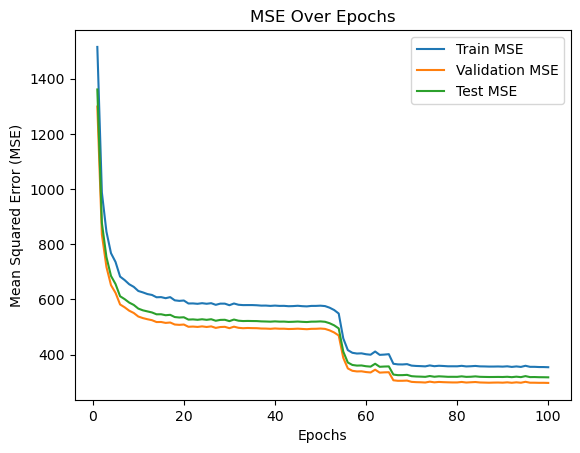

In [21]:
# Number of epochs
epochs = len(train_losses)

# Plotting the MSE over epochs
plt.plot(range(1, epochs + 1), train_losses, label='Train MSE')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation MSE')
plt.plot(range(1, epochs + 1), test_losses, label='Test MSE')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Over Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.show()

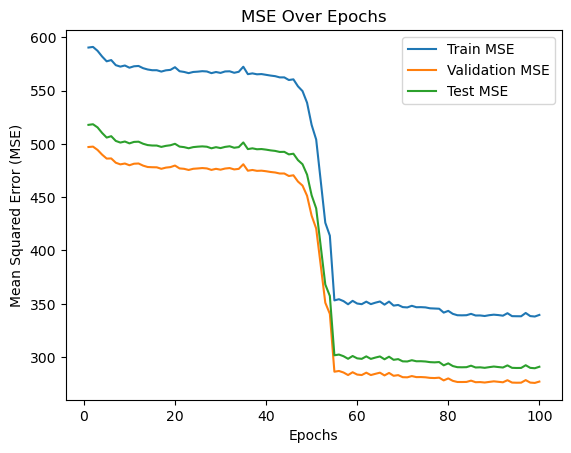

In [14]:
# Number of epochs
epochs = len(train_losses)

# Plotting the MSE over epochs
plt.plot(range(1, epochs + 1), train_losses, label='Train MSE')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation MSE')
plt.plot(range(1, epochs + 1), test_losses, label='Test MSE')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Over Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [22]:
print(train_losses)
print(valid_losses)
print(test_losses)

[1515.1858239193512, 987.39845436002, 845.4015068556546, 767.3601577429124, 735.4308780387596, 682.4492985525249, 669.823004137832, 654.7273302274476, 645.2071510205053, 630.2779587168752, 625.1662854167168, 619.1538015687416, 615.9086337148408, 607.4969497099826, 608.0615944725005, 604.1600400508677, 608.0178572493816, 596.425039205041, 594.4467499265945, 595.7465655244426, 584.9464107482031, 585.2262195618555, 583.7887805106709, 586.0633413526747, 583.9345788759459, 586.032729686533, 580.0995626410339, 584.4142891605204, 584.3647152543558, 578.7205272564672, 584.9503622879216, 580.3106119132336, 579.116076936447, 579.2268867335692, 579.2166912565506, 578.5650016093941, 577.2364029511502, 577.4034827981957, 576.2445493470494, 577.3314368871995, 576.2161124822044, 576.3862913469228, 575.0956525527891, 575.5458039099296, 576.7014417452086, 575.2142369148662, 574.4826463769983, 576.1553441428354, 576.2333256913802, 577.0136213106383, 575.5138430811251, 569.7359009573979, 561.256200876746

In [7]:
print("Plot results 10 epochs")


test_loss = evaluate_AE(mmodel=model, current_graphs=test_graphs, batch_size=batch_size, num_classes=num_classes, device=device, out_dir=out_dir, last_round=True)
print("Evaluate: loss on test: ", test_loss)

write_acc.close()

Plot results 10 epochs
Total MSE loss:  39686.21728515625
Total num graphs:  60


NetworkXError: Input array must be 2D, not 1